# Time Series Forecasting

Author: Charles Liu

This notebook includes the data preprocessing, model creation, training, testing and visualizations

This forecasting model can be treated in two ways:
  1. Regression: predict the close price of the next day, where the price is numeric.
  2. Classification: predict the future close return to positive or negative

## Part I. Close Price Forecasting

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


TICKER = 'CBA'
MISSING_VALUE_STRAGETY = 'mean'

## Prepare data

### Select a ticker and read the data to data frame

In [2]:
# Read dataframe. Here only a dates with valid prices of the selected ticker is read
from pricedata import read_stock_data, read_dates
df_raw = read_stock_data(TICKER)

print("Raw data shape:",  df_raw.shape)
df_raw.head()

Raw data shape: (879, 5)


,open,high,low,close,volume
date,,,,,
2015-01-02,85.42,85.74,85.12,85.74,944323
2015-01-05,85.70,86.24,85.51,85.95,1344368
2015-01-06,85.10,85.80,84.87,85.30,2463926
2015-01-07,85.31,85.49,84.55,85.11,2115727
2015-01-08,85.54,85.65,85.13,85.39,1986996


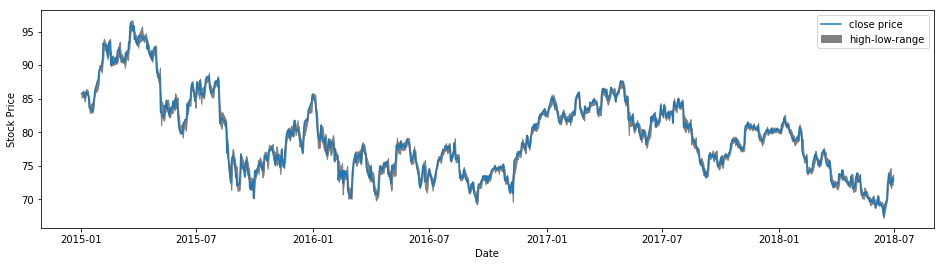

In [3]:
# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
df = df_raw
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Handling missing data.

In the base model, missing data in each column is filled with mean values columns

In [4]:
if MISSING_VALUE_STRAGETY is None:
    df_full = df_raw

In [5]:
if MISSING_VALUE_STRAGETY == 'mean':
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)


    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]

    print("Raw data shape:",  df_full.shape)

    df_full.head()

In [6]:
if MISSING_VALUE_STRAGETY == 'mean':
    # Read full trading dates and create a dataframe with full trading dates. 
    from sklearn.preprocessing import Imputer
    imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)
    imputer.fit(df_raw.values)

    X = imputer.transform(df_full.values)
    df_full = pd.DataFrame(X, index=df_full.index, columns=df_full.columns)
    df_full.head()

In [7]:
if MISSING_VALUE_STRAGETY == 'interpolate':
    # Read full trading dates and create a dataframe with full trading dates. 
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)

    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    df_full.shape

    # Fill the NaN with time interpolation
    if df_full.isna().sum().sum() > 0:
        df_full = df_full.interpolate(method='linear')
    df_full.head()

In [8]:
if MISSING_VALUE_STRAGETY == '0':
    # Read full trading dates and create a dataframe with full trading dates. 
    dates = read_dates()
    if len(dates) > len(df_raw):
        df_full = pd.DataFrame(data=0, index=dates, columns=df_raw.columns, dtype=float)
        df_full.loc[df_raw.index] = df_raw.astype(float)

    # Discard the dates before the first valid data
    df_full = df_full.loc[df_raw.index[0]:]
    df_full.head()

2. Scaling

For stock prices and trading volumes, the Min-Max scaler is an appropriate scaler. In contrast, the standard scaler will produce negative values which make no sense in this occasion.

In [9]:
from sklearn.preprocessing import MinMaxScaler as Scaler
scaler = Scaler(feature_range = (0, 1))
X = scaler.fit_transform(df_full.values)
df_scaled = pd.DataFrame(index=df_full.index, data=X, columns=df_full.columns)
df_scaled.head()

,open,high,low,close,volume
2015-01-02,0.619147,0.619395,0.634752,0.633530,0.019451
2015-01-05,0.628931,0.636774,0.648582,0.640804,0.049284
2015-01-06,0.607966,0.621481,0.625887,0.618289,0.132774
2015-01-07,0.615304,0.610706,0.614539,0.611708,0.106807
2015-01-08,0.623340,0.616267,0.635106,0.621406,0.097207


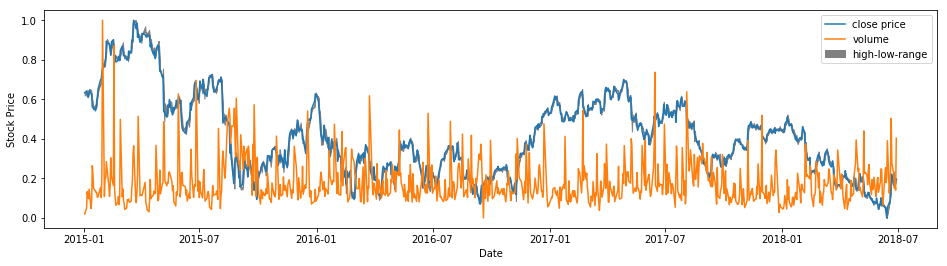

In [10]:
# Visualize the scaled data. 
df = df_scaled
fig = plt.figure(figsize=(16, 4))
plt.plot(df.index, df['close'], "-", label='close price')
plt.fill_between(df.index, y1=df['low'], y2=df['high'], color='gray', label='high-low-range')
plt.plot(df.index, df['volume'], label='volume')
plt.xlabel("Date")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

### Prepare the training, validation and test data
Here are about my feature selection.
   1. Input features: The Open, high, low and high prices and the trading volume are used.
   2. Look back time: 5 days, i.e. totally 25 features will be used.
   3. Target feature: the close price of the next day

In [11]:
lookback = 5
features = 5
delay = 1

total_samples = len(df_full) - lookback - delay + 1
training_samples = int(total_samples * 0.6)
validation_samples = int(total_samples * 0.2)
test_samples = total_samples - training_samples - validation_samples

print("Total samples:", total_samples)
print("Training:", training_samples)
print("Validation:", validation_samples)
print("Test:", test_samples)

Total samples: 878
Training: 526
Validation: 175
Test: 177


In [12]:
from helpers import sample_generator, vectorize_input, vectorize_target

sample_generator = sample_generator(df_scaled, lookback=lookback, delay=delay, target_col=3)
sample_data = list(sample_generator)

# np.random.shuffle(sample_data)

X_data = vectorize_input(sample_data)
y_data = vectorize_target(sample_data)

X_train = X_data[:training_samples]
y_train = y_data[:training_samples]

X_valid = X_data[training_samples: training_samples + validation_samples]
y_valid = y_data[training_samples: training_samples + validation_samples]

X_test = X_data[training_samples + validation_samples: ]
y_test = y_data[training_samples + validation_samples: ]


X_train = X_train.reshape(X_train.shape[0], 1, lookback * features)
X_valid = X_valid.reshape(X_valid.shape[0], 1, lookback * features)
X_test = X_test.reshape(X_test.shape[0], 1, lookback * features)

X_train.shape

(526, 1, 25)

### A forecasting model using recurrent neural networks

In [13]:
from keras.models import Sequential
from keras import layers

units = 64

model = Sequential()

model.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units, return_sequences=True))
model.add(layers.Dropout(rate=0.1))

model.add(layers.LSTM(units=units))
model.add(layers.Dropout(rate=0.1))

model.add(layers.Dense(units=units, activation='relu'))

model.add(layers.Dense(units=1))
    
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, epochs=100, batch_size=lookback* features, validation_data=(X_valid, y_valid))

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 5s 10ms/step - loss: 0.3123 - val_loss: 0.1197
Epoch 2/100
526/526 [==============================] - 0s 717us/step - loss: 0.1429 - val_loss: 0.1017
Epoch 3/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0857 - val_loss: 0.0423
Epoch 4/100
526/526 [==============================] - 0s 747us/step - loss: 0.0540 - val_loss: 0.0579
Epoch 5/100
526/526 [==============================] - 0s 782us/step - loss: 0.0551 - val_loss: 0.0413
Epoch 6/100
526/526 [==============================] - 0s 789us/step - loss: 0.0543 - val_loss: 0.0332
Epoch 7/100
526/526 [==============================] - 0s 777us/step - loss: 0.0546 - val_loss: 0.0365
Epoch 8/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0544 - val_loss: 0.0313
Epoch 9/100
526

526/526 [==============================] - 0s 804us/step - loss: 0.0351 - val_loss: 0.0262
Epoch 75/100
526/526 [==============================] - 0s 828us/step - loss: 0.0371 - val_loss: 0.0296
Epoch 76/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0374 - val_loss: 0.0257
Epoch 77/100
526/526 [==============================] - 0s 809us/step - loss: 0.0357 - val_loss: 0.0352
Epoch 78/100
526/526 [==============================] - 0s 821us/step - loss: 0.0361 - val_loss: 0.0309
Epoch 79/100
526/526 [==============================] - 0s 811us/step - loss: 0.0372 - val_loss: 0.0312
Epoch 80/100
526/526 [==============================] - 0s 816us/step - loss: 0.0403 - val_loss: 0.0236
Epoch 81/100
526/526 [==============================] - 1s 1ms/step - loss: 0.0355 - val_loss: 0.0234
Epoch 82/100
526/526 [==============================] - 0s 805us/step - loss: 0.0349 - val_loss: 0.0257
Epoch 83/100
526/526 [==============================] - 0s 793us/step - loss: 0.0

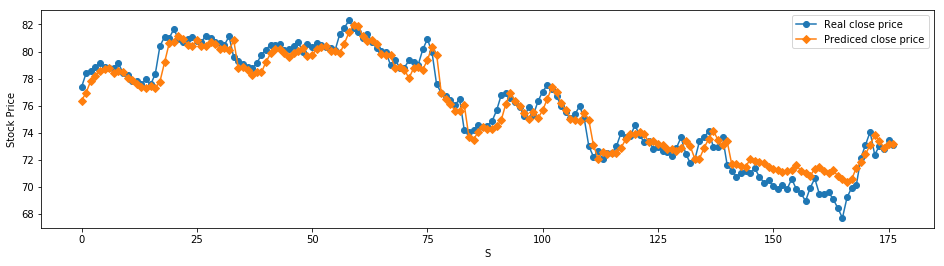

In [19]:
# Predict the model
y_test_real = y_test
y_test_pred = model.predict(X_test).reshape(-1,)

# Inverse the scale
y_test_real = scaler.inverse_transform(np.array([y_test_real] * 5).transpose())[:,0]
y_test_pred = scaler.inverse_transform(np.array([y_test_pred] * 5).transpose())[:,0]


# Visualize the raw data. We see the the variance of the prices on a day is much smaller than the prices across time.
fig = plt.figure(figsize=(16, 4))
plt.plot(y_test_real, "o-", label='Real close price')
#plt.plot(range(1, len(y_test_real) + 1), y_test_real, "s-", label='Real close price')
plt.plot(y_test_pred, "D-", label='Prediced close price')
plt.xlabel("S")
plt.ylabel('Stock Price')
plt.legend()
plt.show()
plt.close()

## Part II:  Binary classification of future close return

In [15]:
from keras.utils import to_categorical

def future_close_return(X, y):
    fcr =  y / X[:, 0, -2] - 1
    return fcr 
    
    
train_labels = future_close_return(X_train, y_train) > 0
valid_labels = future_close_return(X_valid, y_valid) > 0
test_labels = future_close_return(X_test, y_test) > 0


units = 64

classifier = Sequential()

classifier.add(layers.LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
classifier.add(layers.Dropout(rate=0.2))

classifier.add(layers.LSTM(units=units))
classifier.add(layers.Dropout(rate=0.2))

# classifier.add(layers.Dense(units, activation='relu'))

classifier.add(layers.Dense(1, activation='sigmoid'))
    
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
classification_history = classifier.fit(X_train, train_labels, epochs=100, batch_size=lookback * features,
                                        validation_data=(X_valid, valid_labels))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  after removing the cwd from sys.path.


Train on 526 samples, validate on 175 samples
Epoch 1/100
526/526 [==============================] - 3s 6ms/step - loss: 0.6936 - acc: 0.4791 - val_loss: 0.6936 - val_acc: 0.4800
Epoch 2/100
526/526 [==============================] - 0s 433us/step - loss: 0.6936 - acc: 0.4867 - val_loss: 0.6936 - val_acc: 0.4800
Epoch 3/100
526/526 [==============================] - 0s 456us/step - loss: 0.6932 - acc: 0.4981 - val_loss: 0.6943 - val_acc: 0.4800
Epoch 4/100
526/526 [==============================] - 0s 464us/step - loss: 0.6927 - acc: 0.4886 - val_loss: 0.6955 - val_acc: 0.4800
Epoch 5/100
526/526 [==============================] - 0s 463us/step - loss: 0.6931 - acc: 0.4924 - val_loss: 0.6943 - val_acc: 0.4800
Epoch 6/100
526/526 [==============================] - 0s 823us/step - loss: 0.6934 - acc: 0.4924 - val_loss: 0.6929 - val_acc: 0.5200
Epoch 7/100
526/526 [==============================] - 0s 467us/step - loss: 0.6929 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.4914
Epoch 8/100

Epoch 61/100
526/526 [==============================] - 0s 487us/step - loss: 0.6905 - acc: 0.5323 - val_loss: 0.6931 - val_acc: 0.4971
Epoch 62/100
526/526 [==============================] - 0s 499us/step - loss: 0.6910 - acc: 0.5171 - val_loss: 0.6927 - val_acc: 0.5314
Epoch 63/100
526/526 [==============================] - 0s 503us/step - loss: 0.6902 - acc: 0.5209 - val_loss: 0.6925 - val_acc: 0.5314
Epoch 64/100
526/526 [==============================] - 0s 510us/step - loss: 0.6912 - acc: 0.5190 - val_loss: 0.6927 - val_acc: 0.5371
Epoch 65/100
526/526 [==============================] - 0s 842us/step - loss: 0.6921 - acc: 0.5380 - val_loss: 0.6925 - val_acc: 0.5200
Epoch 66/100
526/526 [==============================] - 0s 490us/step - loss: 0.6916 - acc: 0.5209 - val_loss: 0.6934 - val_acc: 0.4857
Epoch 67/100
526/526 [==============================] - 0s 489us/step - loss: 0.6900 - acc: 0.5209 - val_loss: 0.6930 - val_acc: 0.5029
Epoch 68/100
526/526 [==========================

In [16]:
# def future_close_return(X, y):
#     fcr =  y / X[:, 0, -2] - 1
#     return fcr 
    
# train_labels = future_close_return(X_train, y_train) > 0
# valid_labels = future_close_return(X_valid, y_valid) > 0
# test_labels = future_close_return(X_test, y_test) > 0

# X_train_2 = X_train.reshape(X_train.shape[0], lookback * features)
# X_valid_2 = X_valid.reshape(X_valid.shape[0], lookback * features)

# units = 64

# classifier = Sequential()

# classifier.add(layers.Dense(units, activation='relu', input_shape=(lookback * features,)))

# classifier.add(layers.Dense(units, activation='relu'))

# classifier.add(layers.Dense(units, activation='relu'))

# classifier.add(layers.Dropout(rate=0.2))

# classifier.add(layers.Dense(1, activation='sigmoid'))
    
# classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
# classification_history = classifier.fit(X_train_2, train_labels, epochs=200, batch_size=lookback * features,
#                                         validation_data=(X_valid_2, valid_labels))

In [17]:
# df = df_scaled
# df.close / df.close.shift(1) - 1